<a href="https://colab.research.google.com/github/StanleyLiangYork/2024_journal_club_Transformer_AI/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from packaging.version import parse as parse_version

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete1Q9W41/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete1Q9W41/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


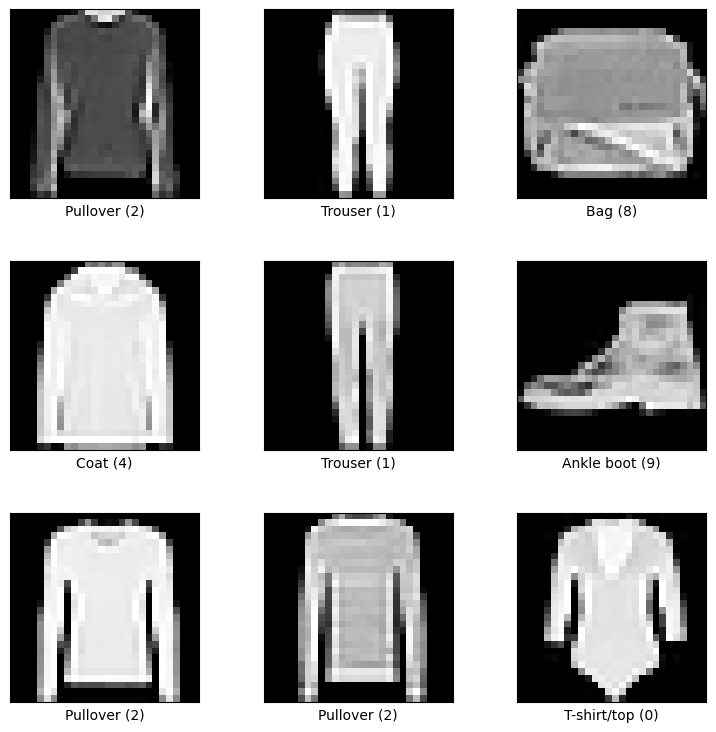

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path=PosixGPath('/tmp/tmpacxiikd5tfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao a

In [ ]:
ds_train, ds_info = tfds.load('fashion_mnist', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_info, ds_train)
ds_info

In [ ]:
batch_size = 256
image_shape = (28, 28, 1)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    return image

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(ds_info.splits['train'].num_examples).batch(batch_size).prefetch(1)
train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

234


In [ ]:
class GAN():
    def __init__(self, generator, discriminator):
        # discriminator
        self.D = discriminator
        self.G = generator

        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.d_loss = {}
        self.g_loss = {}
        self.accuracy = {}
        self.g_gradients = []

    def discriminator_loss(self, pred_fake, pred_real):
        real_loss = self.bce(tf.ones_like(pred_real), pred_real)
        fake_loss = self.bce(tf.zeros_like(pred_fake), pred_fake)

        d_loss = 0.5*(real_loss + fake_loss)
        return d_loss

    def generator_loss(self, pred_fake):
        g_loss = self.bce(tf.ones_like(pred_fake), pred_fake)
        return g_loss

In [ ]:
def Discriminator(input_shape):
    model = tf.keras.Sequential(name='Discriminator')
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, 3, strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, 3, strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
discriminator = Discriminator(image_shape)

In [ ]:
def Generator(z_dim):
    model = tf.keras.Sequential(name='Generator')
    model.add(layers.Input(shape=[z_dim]))

    model.add(layers.Dense(7*7*64))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.ReLU())
    model.add(layers.Reshape((7,7,64)))

    model.add(layers.Conv2D(64, 3, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.ReLU())
    model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))

    model.add(layers.Conv2D(32, 3, padding='same'))
    model.add(layers.ReLU())
    model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))

    model.add(layers.Conv2D(image_shape[-1], 3, padding='same', activation='tanh'))

    return model

In [ ]:
z_dim = 100
generator = Generator(z_dim)

In [ ]:
def plot_images(images):
    grid_row = 1
    grid_col = 8
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
    for col in range(grid_col):
        axarr[col].imshow((images[col,:,:,0]+1)/2, cmap='gray')
        axarr[col].axis('off')
    plt.show()

In [ ]:
def z_generator(batch_size, z_dim=100):
    return tf.random.normal((batch_size, z_dim))

In [ ]:
gan = GAN(generator=generator, discriminator=discriminator)

In [ ]:
gan.D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                     

In [ ]:
gan.G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization_2 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                         

In [ ]:
# g_optimizer = RMSprop(3e-4)
# d_optimizer = RMSprop(3e-4)
g_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
d_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)

In [ ]:
def train_step(g_input, real_input):
    # two gradient recorders: g and d
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        # feed forward
        fake_input = gan.G(g_input)
        pred_fake = gan.D(fake_input)
        pred_real = gan.D(real_input)
        # Calculate losses
        d_loss = gan.discriminator_loss(pred_fake, pred_real)
        g_loss = gan.generator_loss(pred_fake)
        # Accuracy
        fake_accuracy = tf.math.reduce_mean(binary_accuracy(tf.zeros_like(pred_fake), pred_fake))
        real_accuracy = tf.math.reduce_mean(binary_accuracy(tf.ones_like(pred_real), pred_real))
        # backprop gradients
        gradient_g = g_tape.gradient(g_loss, gan.G.trainable_variables)
        gradient_d = d_tape.gradient(d_loss, gan.D.trainable_variables)
        # get the L1 norm of the the gradient g
        gradient_g_l1_norm = [tf.norm(gradient).numpy() for gradient in gradient_g]
        gan.g_gradients.append(gradient_g_l1_norm)
        # update weights
        g_optimizer.apply_gradients(zip(gradient_g, gan.G.trainable_variables))
        d_optimizer.apply_gradients(zip(gradient_d, gan.D.trainable_variables))

    return g_loss, d_loss, fake_accuracy, real_accuracy

run the train loop

Epoch 1: d_loss 0.5953 g_loss 0.7824 == Accuracy: 0.720 == epoch-time: 33.502


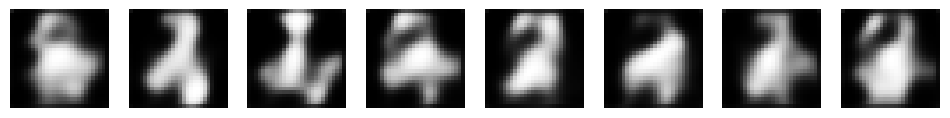

Epoch 2: d_loss 0.6001 g_loss 0.8414 == Accuracy: 0.751 == epoch-time: 20.689


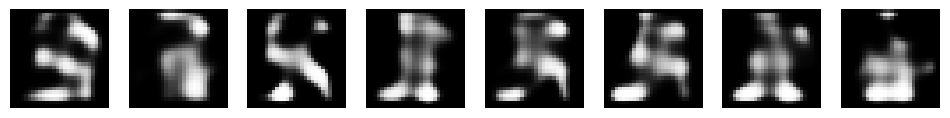

Epoch 3: d_loss 0.4741 g_loss 1.1495 == Accuracy: 0.833 == epoch-time: 20.756


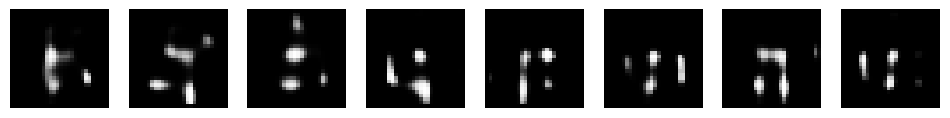

Epoch 4: d_loss 0.3827 g_loss 1.4110 == Accuracy: 0.864 == epoch-time: 20.817


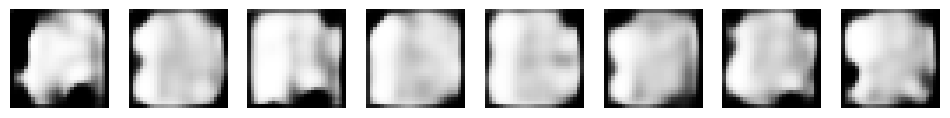

Epoch 5: d_loss 0.3933 g_loss 1.4938 == Accuracy: 0.865 == epoch-time: 20.690


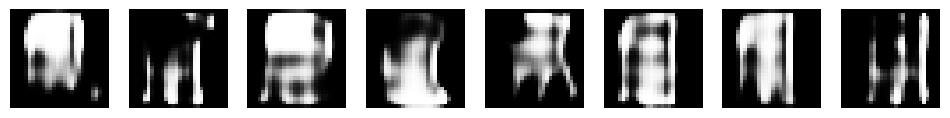

Epoch 6: d_loss 0.3924 g_loss 1.8344 == Accuracy: 0.806 == epoch-time: 20.797


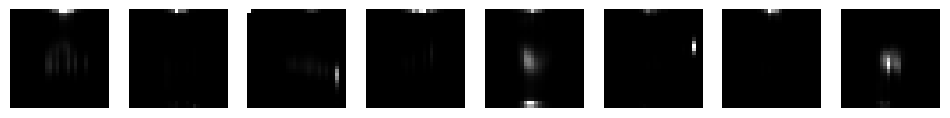

Epoch 7: d_loss 0.3791 g_loss 1.9589 == Accuracy: 0.861 == epoch-time: 20.737


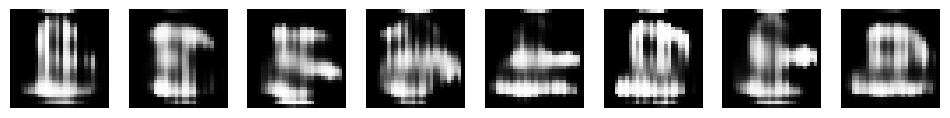

Epoch 8: d_loss 0.4954 g_loss 1.2248 == Accuracy: 0.783 == epoch-time: 21.043


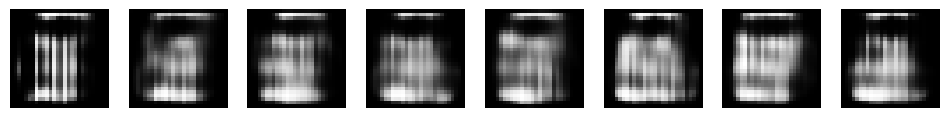

Epoch 9: d_loss 0.5562 g_loss 1.1484 == Accuracy: 0.746 == epoch-time: 20.894


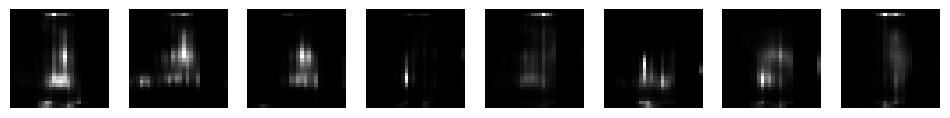

Epoch 10: d_loss 0.3733 g_loss 1.3949 == Accuracy: 0.899 == epoch-time: 21.055


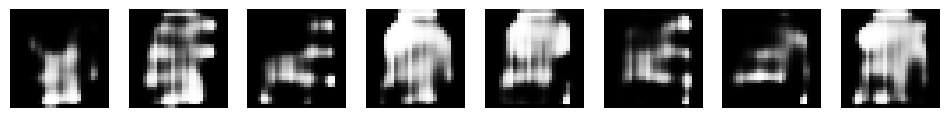

Epoch 11: d_loss 0.3539 g_loss 1.3933 == Accuracy: 0.896 == epoch-time: 20.910


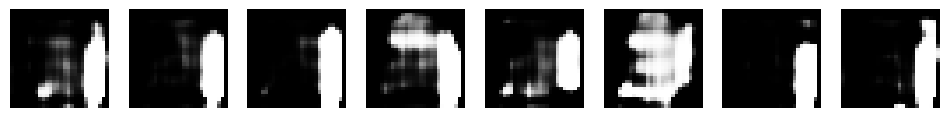

Epoch 12: d_loss 0.2224 g_loss 2.0699 == Accuracy: 0.934 == epoch-time: 20.987


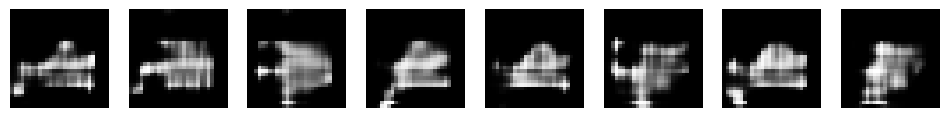

Epoch 13: d_loss 0.4137 g_loss 1.9355 == Accuracy: 0.856 == epoch-time: 20.363


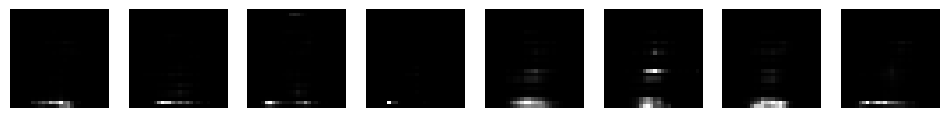

Epoch 14: d_loss 0.0976 g_loss 3.4675 == Accuracy: 0.973 == epoch-time: 20.098


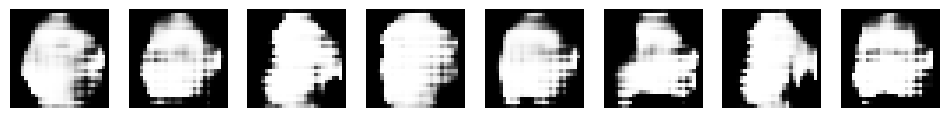

Epoch 15: d_loss 0.4796 g_loss 1.2158 == Accuracy: 0.804 == epoch-time: 20.086


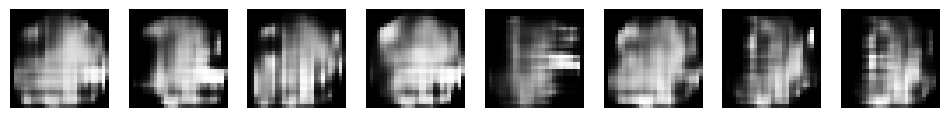

Epoch 16: d_loss 0.4331 g_loss 1.4139 == Accuracy: 0.832 == epoch-time: 20.330


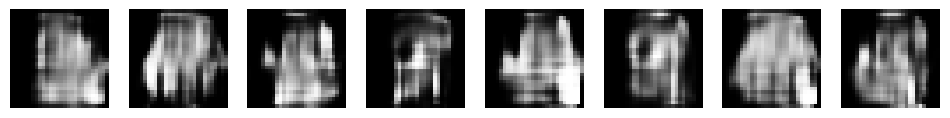

Epoch 17: d_loss 0.3808 g_loss 1.4787 == Accuracy: 0.862 == epoch-time: 20.390


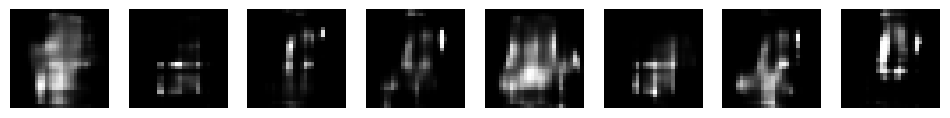

Epoch 18: d_loss 0.3890 g_loss 1.3546 == Accuracy: 0.870 == epoch-time: 20.240


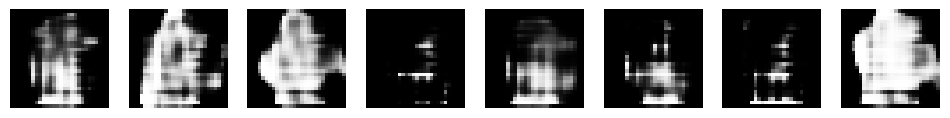

Epoch 19: d_loss 0.4171 g_loss 1.2730 == Accuracy: 0.846 == epoch-time: 20.183


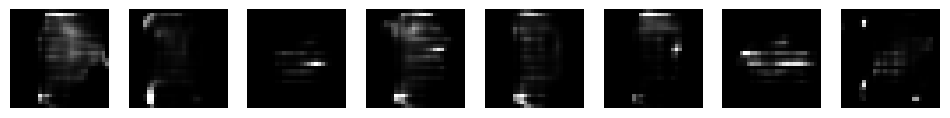

Epoch 20: d_loss 0.3959 g_loss 1.6775 == Accuracy: 0.847 == epoch-time: 20.163


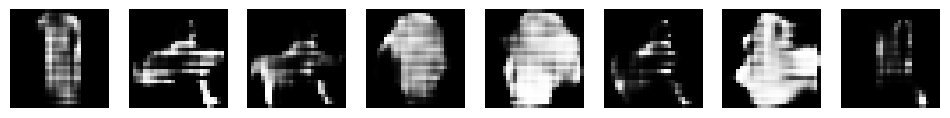

Epoch 21: d_loss 0.4012 g_loss 1.4629 == Accuracy: 0.858 == epoch-time: 20.145


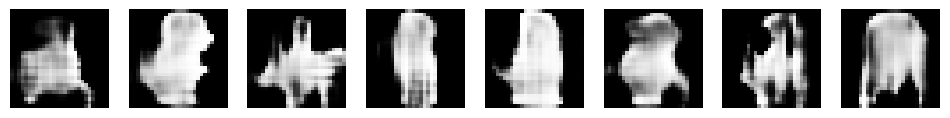

Epoch 22: d_loss 0.4005 g_loss 1.6104 == Accuracy: 0.837 == epoch-time: 20.259


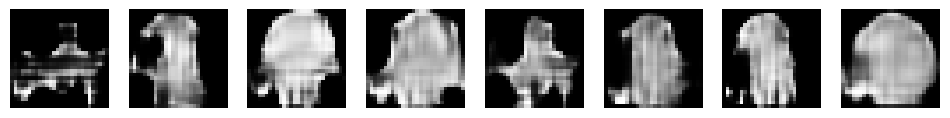

Epoch 23: d_loss 0.4113 g_loss 1.2734 == Accuracy: 0.852 == epoch-time: 20.207


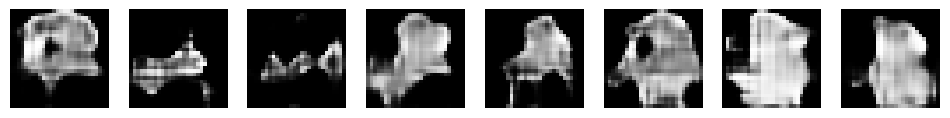

Epoch 24: d_loss 0.4002 g_loss 1.3856 == Accuracy: 0.847 == epoch-time: 20.294


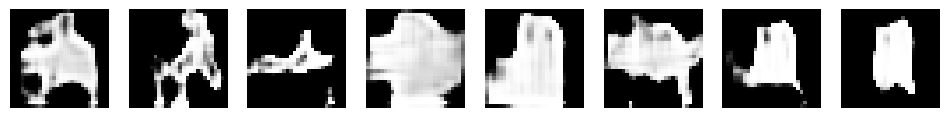

Epoch 25: d_loss 0.4479 g_loss 1.2868 == Accuracy: 0.816 == epoch-time: 20.397


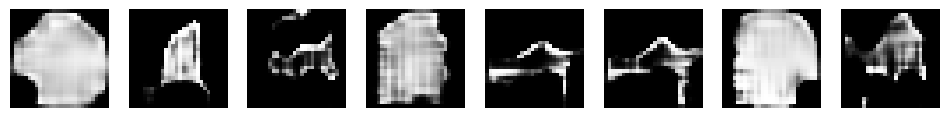

Epoch 26: d_loss 0.4352 g_loss 1.3747 == Accuracy: 0.811 == epoch-time: 20.370


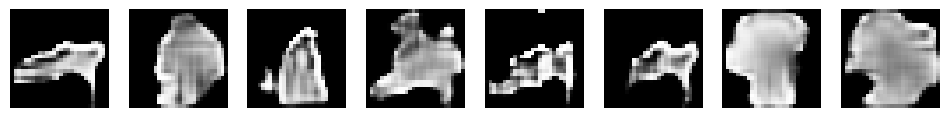

Epoch 27: d_loss 0.4227 g_loss 1.3147 == Accuracy: 0.826 == epoch-time: 20.278


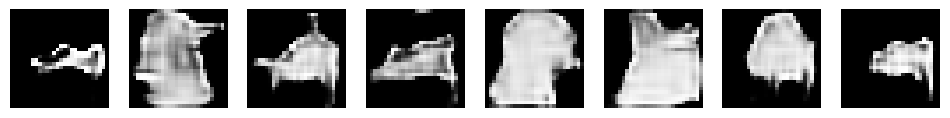

Epoch 28: d_loss 0.4168 g_loss 1.3798 == Accuracy: 0.829 == epoch-time: 20.180


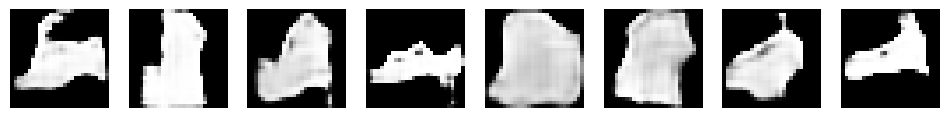

Epoch 29: d_loss 0.4278 g_loss 1.4366 == Accuracy: 0.804 == epoch-time: 20.176


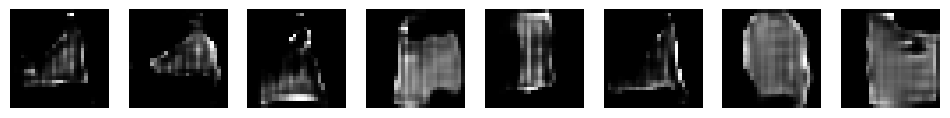

Epoch 30: d_loss 0.4302 g_loss 1.3742 == Accuracy: 0.812 == epoch-time: 20.599


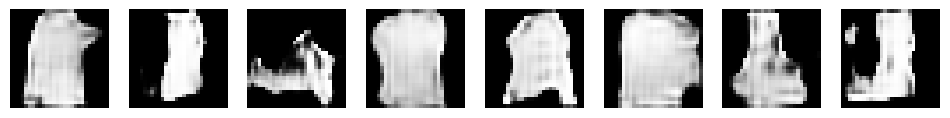

In [ ]:
import time

epochs = 30
history = {}
history['d_loss'] = []
history['g_loss'] = []
history['acc'] = []

for epoch in range(epochs):
    g_loss_list=[]
    d_loss_list=[]
    acc_list=[]

    start_time = time.time()
    for images in ds_train:
        batch_num = images.shape[0]
        g_input = z_generator(batch_num)
        real_input = images
        g_loss, d_loss, fake_accuracy, real_accuracy = train_step(g_input, real_input)
        d_loss_list.append(d_loss.numpy())
        g_loss_list.append(g_loss.numpy())
        acc_list.append(0.5*(fake_accuracy.numpy() + real_accuracy.numpy()))

    d_loss_epoch=np.mean(np.array(d_loss_list))
    g_loss_epoch=np.mean(np.array(g_loss_list))
    acc_epoch=np.mean(np.array(acc_list))
    history['d_loss'].append(d_loss_epoch)
    history['g_loss'].append(g_loss_epoch)
    history['acc'].append(acc_epoch)

    end_time = time.time()
    runtime = end_time-start_time
    msg = "Epoch {}: d_loss {:.4f} g_loss {:.4f} == Accuracy: {:.3f} == epoch-time: {:.3f}".format(epoch+1, d_loss_epoch, g_loss_epoch, acc_epoch, runtime)
    print(msg)
    val_g_input = z_generator(batch_size)
    fake_images = gan.G(val_g_input)
    plot_images(fake_images)


Text(0.5, 0, 'Epoch')

<Figure size 1000x600 with 0 Axes>

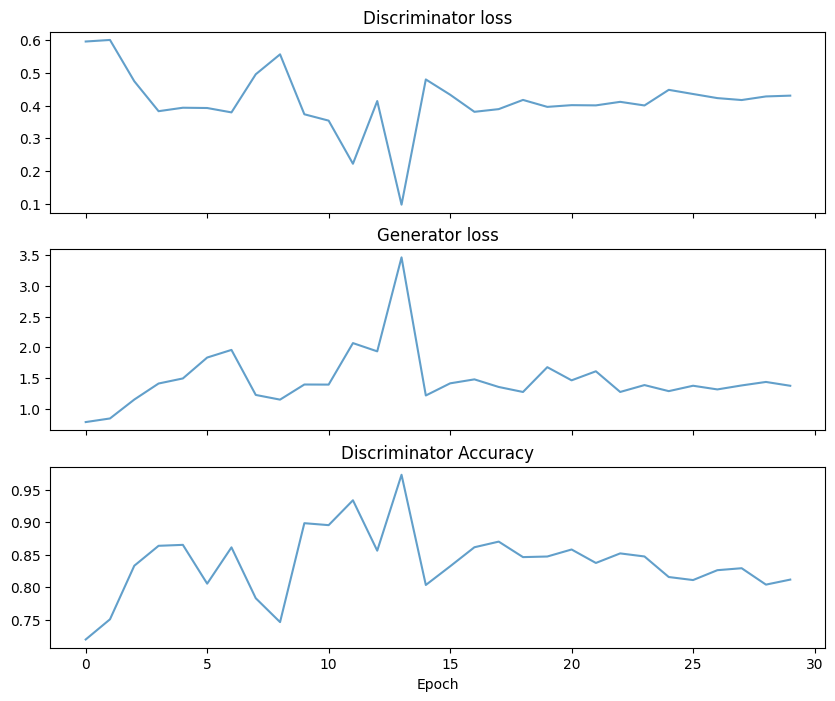

In [ ]:
plt.figure(figsize=(10,6))
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.set_figwidth(10)
fig.set_figheight(8)
ax1.plot(history['d_loss'], label='D loss', alpha=0.7)
ax1.set_title("Discriminator loss")
ax2.plot(history['g_loss'], label='G loss', alpha=0.7)
ax2.set_title("Generator loss")
ax3.plot(history['acc'], label='Accuracy', alpha=0.7)
ax3.set_title("Discriminator Accuracy")
#ax3.set_title("Gradient")
plt.xlabel('Epoch')